# 6 kritérium
 1. Sok adatsor
    -még a 7milliárd sem sok
 2. Sok oszlop
 3. Tiszta adat
 4. Torzítatlan adat
    -pl csak nők vannak egy adatázisbn
 5. Számítható RoI (Return of Investment)
 6. Akcióképesség
    - ha kijön a dolog, szabad-e azt neked visszarakni.
      Pl más fajta hitel nőknek és férfiaknak
 7. Milyen gyorsan derül ki hogy jó vagy rossz a modelled

In [1]:
'''Importok'''
import pandas as pd
import numpy as np
#from sklearn import *

In [2]:
df = pd.read_csv('churn2.txt')
df.head()

IOError: File churn2.txt does not exist

In [ ]:
#Az első egy korábban kiírt DataFrame indexe, amire nincs itt szükségünk, eldobjuk
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
print "Nem churn-olok aranya:\t", len(df[df['Churn?']=="False."])
print "Churn-olok aranya:\t", len(df[df['Churn?']=="True."])
print "Churn-olok aránya:\t", len(df[df['Churn?']=="True."])/(len(df)+0.0)

In [ ]:
#Van neheny oszlop, amit szamma kell konvertalni, van nehany, ami azonosito, es nem kell az elemzesben
df['target'] = pd.Categorical(df['Churn?']).codes
df.drop('Churn?', axis=1, inplace=True)

In [ ]:
df['state_id'] = pd.Categorical(df['State']).codes
df.drop('State', axis=1, inplace=True)

In [ ]:
df['IntlPlan'] = pd.Categorical(df['Int\'l Plan']).codes
df.drop('Int\'l Plan', axis=1, inplace=True)

In [ ]:
df['VMailPlan'] = pd.Categorical(df['VMail Plan']).codes
df.drop('VMail Plan', axis=1, inplace=True)

In [ ]:
df.drop('Phone', axis=1, inplace=True)

In [ ]:
df.head()

In [ ]:
#Ellenorizzuk hogy csak szam van benne
df.dtypes

In [ ]:
#Trukk, hogy az alapstatisztikakat lassuk
df.describe().T

# <FONT color="blue">Modellépítés</FONT>

In [ ]:
from sklearn.cross_validation import train_test_split

train, test = train_test_split(df, test_size = 0.5, random_state = 2014)
print 'train adathalmaz merete:\t',train.shape
print 'test adathalmaz merete:\t\t',test.shape

train_columns = train.columns.difference(['target'])
print '"True" esemenyek szama a train adathalmazban:\t',train[train['target']==1]['target'].count()
print '"True" esemenyek szama a test adathalmazban:\t',test[test['target']==1]['target'].count()

In [ ]:
from sklearn.linear_model import LogisticRegression
logit_classifier = LogisticRegression(C=0.8)
# tovabbi parameterek:
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

### <FONT COLOR="red">Modell tanítása</FONT>

In [ ]:
logit_model = logit_classifier.fit(train[train_columns], train['target'])

In [ ]:
# a modell objektumbol nyerhetok ki a modell parameterei
print 'bias:\t',logit_model.intercept_
print 'koefficiensek:\n',logit_model.coef_[0]

### <FONT color="red"> Modell alkalmazása </FONT>

In [ ]:
test = test.assign(pred = logit_classifier.predict(test[train_columns]))
print '"True" becslesek szama a test adathalmazban:\t',test[test['pred']==1]['pred'].count()

In [ ]:
test['pred'].describe()

In [ ]:
# eloszor letre kell hozni az uj ures oszlopokat, mert egyszerre egynel tobb uj oszlop nem generalhato kozvetlenul
test = pd.concat([test, pd.DataFrame(columns=['proba_0','proba_1'])])

test[['proba_0','proba_1']] = logit_classifier.predict_proba(test[train_columns])
test.head()

In [ ]:
test.proba_1.describe()

# <Font color="blue"> Modell kiértékelése </Font>


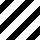
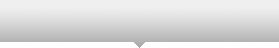
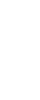
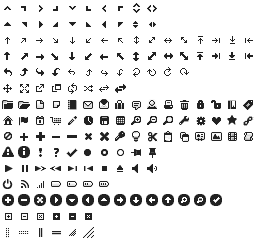
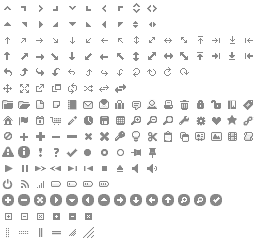
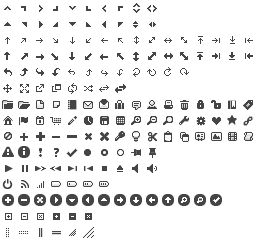
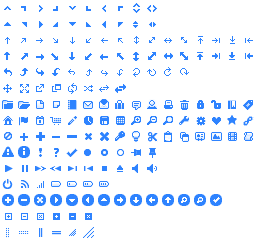
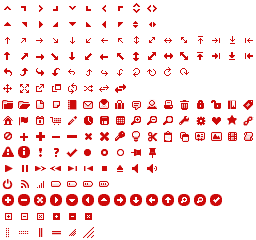
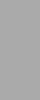
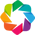
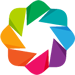
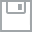
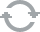
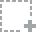
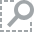
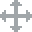
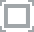
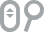

In [6]:
import sklearn.metrics as sk_metr

%matplotlib inline 
import matplotlib.pyplot as plt
import bokeh.plotting as bplt
from bokeh.models import LinearAxis,Range1d,HoverTool
bplt.output_notebook()
TOOLS='pan,wheel_zoom,box_zoom,resize,reset,save'#,hover,crosshair,lasso_select'

## <font color="red">Cummulative sum of target </font>

In [ ]:
# Görbe alatti területet számolunk
test_sorted = test[['target','pred','proba_0','proba_1']].sort('proba_1', ascending=False)
test_sorted['target_cumsum'] = test_sorted['target'].cumsum()
test_sorted.head(20)

In [ ]:
# rank: sortolt listában hanyadik a szereplő
test_sorted['Rank']=range(len(test_sorted))
test_sorted.head()

In [ ]:
bplt_fig_cumsum = bplt.figure(tools=TOOLS, width=400, height=400)


bplt_fig_cumsum.line(test_sorted['Rank'], test_sorted['target_cumsum'], color='#1F78B4', line_width=2)
bplt_fig_cumsum.set(x_range=Range1d(0, test_sorted['Rank'].max()))

bplt_fig_cumsum.xaxis.axis_label='Rank'
bplt_fig_cumsum.yaxis.axis_label='Cumulative sum of target'

bplt.show(bplt_fig_cumsum)

# <Font color="red">Accuracy and AUC </Font>

In [1]:
accuracy = sk_metr.accuracy_score(test['target'], test['pred'])
print 'Accuracy:\t',accuracy

NameError: name 'sk_metr' is not defined

In [3]:
# AUC szamitasa kozvetlenul a celvaltozo es a konfidencia alapjan:
auc = sk_metr.roc_auc_score(test['target'], test['proba_1'])
print 'AUC:\t',auc

# AUC szamitasa az FPR es TPR ertekekbol
fpr_1, tpr_1, thresholds_1 = sk_metr.roc_curve(test['target'], test['proba_1'], pos_label=1)
auc_1 = sk_metr.auc(fpr_1, tpr_1)
print 'AUC:\t',auc_1

# az FPR es TPR alapu AUC szamitasanal nem szamit, hogy mi a positive_class,
# de a megadott target valoszinusegnek es a 'positive_label'-nek osszetartozonak kell lennie
fpr_0, tpr_0, thresholds_0 = sk_metr.roc_curve(test['target'], test['proba_0'], pos_label=0)
auc_0 = sk_metr.auc(fpr_0, tpr_0)
print 'AUC:\t',auc_0

NameError: name 'sk_metr' is not defined

In [4]:
# a terulet kirajzolasahoz hozza kell venni a gorbehez az (1,0) koordinatat, ami osszekoti a (0,0) - (1,1) pontokat
fpr_1_auc = np.append(fpr_1,1)
tpr_1_auc = np.append(tpr_1,0)

bplt_fig_auc = bplt.figure(tools=TOOLS, width=400, height=400)

bplt_fig_auc.patch(fpr_1_auc, tpr_1_auc, color='#1F78B4', alpha=0.2)
bplt_fig_auc.line(fpr_1, tpr_1, color='#1F78B4', line_width=2)

bplt_fig_auc.title = 'Area Under Curve'
bplt_fig_auc.xaxis.axis_label = 'False Positive Rate (1-Specificity)'
bplt_fig_auc.yaxis.axis_label = 'True Positive Rate (Sensitivity)'

bplt.show(bplt_fig_auc)

NameError: name 'fpr_1' is not defined

## <Font color="red" > ROC görbe </Font>

In [8]:
# Genyó görbe, nem függvény
# A ROC gorbe kirajzolasanal szamit, hogy mi a positive_class, ami menten rajzoljuk a gorbet
# ROC gorbe positive_class=0 eseten

bplt_fig_0 = bplt.figure(tools=TOOLS, width=400, height=400)

bplt_fig_0.line(fpr_0, tpr_0, color='#1F78B4', line_width=2, legend='ROC (pos_class=0)')
#bplt_fig_0.line(fpr_0, thresholds_0, color='green', line_width=2, legend='treshold (pos_class=0)')
bplt_fig_0.line([0,1], [0,1], color='red', line_width=2, legend='random guess')
bplt_fig_0.legend.orientation = "bottom_right"

bplt_fig_0.title = 'ROC curve'
bplt_fig_0.xaxis.axis_label = 'False Positive Rate (1-Specificity)'
bplt_fig_0.yaxis.axis_label = 'True Positive Rate (Sensitivity)'

bplt.show(bplt_fig_0)

NameError: name 'fpr_1' is not defined

In [ ]:
# ROC gorbe positive_class=1 eseten

bplt_fig_1 = bplt.figure(tools=TOOLS, width=400, height=400)

bplt_fig_1.line(fpr_1, tpr_1, color='#1F78B4', line_width=2, legend='ROC (pos_class=1)')
#bplt_fig_1.line(fpr_1, thresholds_1, color='green', line_width=2, legend='treshold (pos_class=1)')
bplt_fig_1.line([0,1], [0,1], color='red', line_width=2, legend='random guess')
bplt_fig_1.legend.orientation = "bottom_right"

bplt_fig_1.title = 'ROC curve'
bplt_fig_1.xaxis.axis_label = 'False Positive Rate (1-Specificity)'
bplt_fig_1.yaxis.axis_label = 'True Positive Rate (Sensitivity)'

bplt.show(bplt_fig_1)

### ROC görbe azonos konfidencia szint esetén

In [ ]:
test['proba_fail']=0.7
fpr_fail, tpr_fail, thresholds_fail = sk_metr.roc_curve(test['target'], test['proba_fail'], pos_label=1)
#test.drop('proba_fail', axis=1, inplace=True)

In [ ]:
auc_fail = sk_metr.roc_auc_score(test['target'], test['proba_fail'])
print 'AUC fail:\t',auc_fail

bplt_fig_fail = bplt.figure(tools=TOOLS, width=400, height=400)

bplt_fig_fail.line(fpr_fail, tpr_fail, color='#1F78B4', line_width=2, legend='ROC curve (fail)')
#bplt_fig_fail.line(fpr_fail, thresholds_fail, color='green', line_width=2, legend='treshold (pos_class=1)')
#bplt_fig_fail.line([0,1], [0,1], color='red', line_width=2, legend='random guess')
bplt_fig_fail.legend.orientation = "bottom_right"

bplt_fig_fail.title = 'ROC curve'
bplt_fig_fail.xaxis.axis_label = 'False Positive Rate (1-Specificity)'
bplt_fig_fail.yaxis.axis_label = 'True Positive Rate (Sensitivity)'

bplt.show(bplt_fig_fail)

## <FONT color="red">Profit görbe</FONT>

In [ ]:
df_profit = test[['proba_1','target']]

# rendezzuk a probability_1 alapjan csokkeno sorba az entitasokat
df_profit = df_profit.sort(columns='proba_1', ascending=False)
df_profit = df_profit.reset_index().rename(columns={'index':'id_ori'})
df_profit = df_profit.reset_index().rename(columns={'index':'id_profit'})
# 'id_profit' = ilyen sorrendben hivjuk fel az ugyfeleket, hogy ne churn-oljenek

# mennyit kerestunk egy ugyfelen, ha felhivtuk (akit felhivtunk, de nem churn-olt volna, az koltseg)
df_profit['profit'] = df_profit['target'].apply(lambda x: 14000 if x==1 else -1000)

# mindig a kovetkezo legnagyobb valoszinuseggel churn-olo ugyfelet hivjuk fel; mennyit keresunk igy?
df_profit['profit_cumsum'] = df_profit['profit'].cumsum()
df_profit.head()

In [ ]:
bplt_fig_profit = bplt.figure(tools=TOOLS, width=800, height=400)

bplt_fig_profit.line(df_profit['id_profit'], df_profit['profit_cumsum'], color='#1F78B4', line_width=2, legend='Profit curve')
bplt_fig_profit.line([0,len(df_profit)], [0,0], color='red', line_width=2, legend='baseline')
bplt_fig_profit.legend.orientation = "top_right"
bplt_fig_profit.left[0].formatter.use_scientific = False

bplt_fig_profit.title = 'Profit curve'
bplt_fig_profit.xaxis.axis_label = 'Call order of customers'
bplt_fig_profit.yaxis.axis_label = 'Cumulative sum of profit'

bplt.show(bplt_fig_profit)
print "Maxprofit:", df_profit['profit_cumsum'].max()


## <Font color="red">Lift görbe</Font>

In [ ]:
df_lift = test[['proba_1','target']]

# rendezzuk a probability_1 alapjan csokkeno sorba az entitasokat
df_lift = df_lift.sort(columns='proba_1', ascending=False)
df_lift = df_lift.reset_index().rename(columns={'index':'id_ori'})
df_lift = df_lift.reset_index().rename(columns={'index':'id_lift'})

len_df_lift = len(df_lift.index)
lift_values = []

# szamoljuk ki a teljes adathalmazra az 1-es targetek es a teljes adathalmaz darabszamanak aranyat
lift_all=df_lift['target'].sum()/float(len_df_lift)

# minden centilisben...
for i in range(99):
    # nezzuk meg, hogy mely entitasok tartoznak az adott centilisbe
    df_lift['lift_'+str(i)+'0_perc'] = df_lift['id_lift'].apply(lambda x: 1 if x<len_df_lift*(i+1)*0.01 else 0)

    # szamoljuk ki az adott centilisben levo 1-es targetek es az adott centilis darabszamanak aranyat
    lift_0 = df_lift[df_lift['lift_'+str(i)+'0_perc']==1]['target'].sum()/\
        float(df_lift[df_lift['lift_'+str(i)+'0_perc']==1]['target'].count())

    # a teljes adathalmazra vonatkozo aranyszamot osszuk el a centilisre ervenyes aranyszammal
    lift_values.append(lift_0/float(lift_all))

In [ ]:
bplt_fig_lift = bplt.figure(tools=TOOLS, width=600, height=400)

bplt_fig_lift.line(range(99), lift_values, color='#1F78B4', line_width=2, legend='Lift curve')
bplt_fig_lift.line([0,100], [1,1], color='red', line_width=2, legend='baseline')
bplt_fig_lift.legend.orientation = "top_right"

bplt_fig_lift.title = 'Lift curve'
bplt_fig_lift.xaxis.axis_label = 'Percentiles'
bplt_fig_lift.yaxis.axis_label = 'Lift value'

bplt.show(bplt_fig_lift)